# Model 3: Altered Variable of Interest to COVID-19 Deaths

## Purpose: Explore the effect of COVID-19 Deaths on Mobility Trends
### Based on the following model: 
\begin{align}
Mobility = \beta_0 + \beta_1 Weekly Net Death Change + \beta_2 Population + \beta_3 Income + \beta_4  Trump Support + \beta_5 PhaseOne + \beta_6 PhaseTwo + \beta_7 PhaseThree + \beta_8 Precipitation + \epsilon
\end{align}

* Linear Regression
* K Nearest Neighbors
* Decision Tree
* Random Forest
* Bagging

## Dependencies

In [1]:
## Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

## Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

## For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.linear_model import LinearRegression as LM
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

## For evaluating our model's performance
import sklearn.metrics as m

## Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

## For evaluating variable importance
from sklearn.inspection import permutation_importance

## For Partial Dependency
from pdpbox import pdp

## For Multiple Outputs 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
## Read in analysis data
dta0 = pd.read_csv('data/build/build5_analysis_data.csv')

dta0.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths,country_region_code,country_region,sub_region_1,...,delta_death04,delta_death05,delta_death06,weekly_delta_deaths,phase_1,phase_2,phase_3,Pop_2019,lag_cm,delta_cm
0,2020-03-17,51001,Accomack,Eastern Shore,0,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,NaN,NaN
1,2020-03-18,51001,Accomack,Eastern Shore,0,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,-8.0,-7.0
2,2020-03-19,51001,Accomack,Eastern Shore,0,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,-15.0,-1.0
3,2020-03-20,51001,Accomack,Eastern Shore,1,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,-16.0,-1.0
4,2020-03-21,51001,Accomack,Eastern Shore,1,0,0,US,United States,Virginia,...,NaN,NaN,NaN,NaN,False,False,False,32316,-17.0,-7.0


In [3]:
## Specify y and X variables
y_var = ['retail_and_recreation_percent_change_from_baseline']

X_vars = ['weekly_delta_deaths','Pop_2019','DP03_0062E','P_Republican','phase_1','phase_2','phase_3']

var = y_var + X_vars

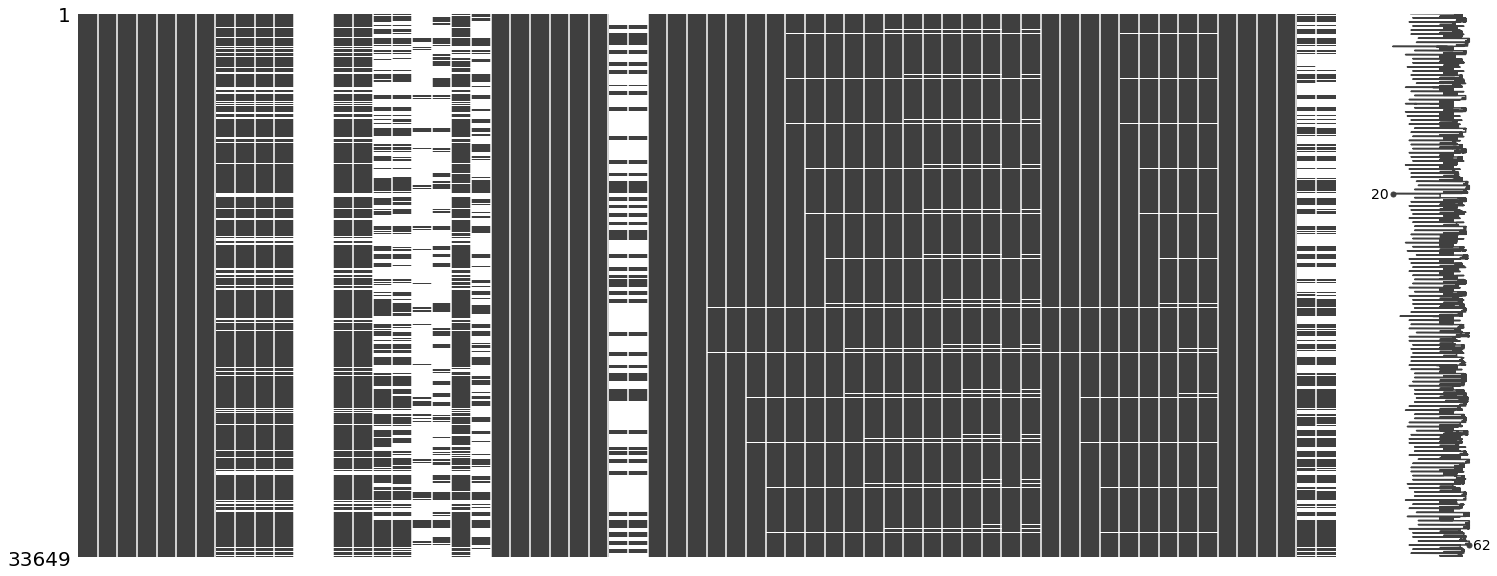

In [4]:
Viz_missing = miss.matrix(dta0)

In [5]:
## Check original count
dta0.shape

## Remove rows with missing values in variables of interest
dta1 = dta0.dropna(subset= var)

## Check count
dta1.shape

(33649, 64)

(17406, 64)

In [6]:
## Subset data into y and X
y = dta1[y_var]

X = dta1[X_vars]

## Split into training and test data
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=12)

## Check dimensions of data
round(train_X.shape[0]/dta1.shape[0], 4)
train_X.shape[0]

round(test_X.shape[0]/dta1.shape[0], 4)

0.75

13054

0.25

<AxesSubplot:>

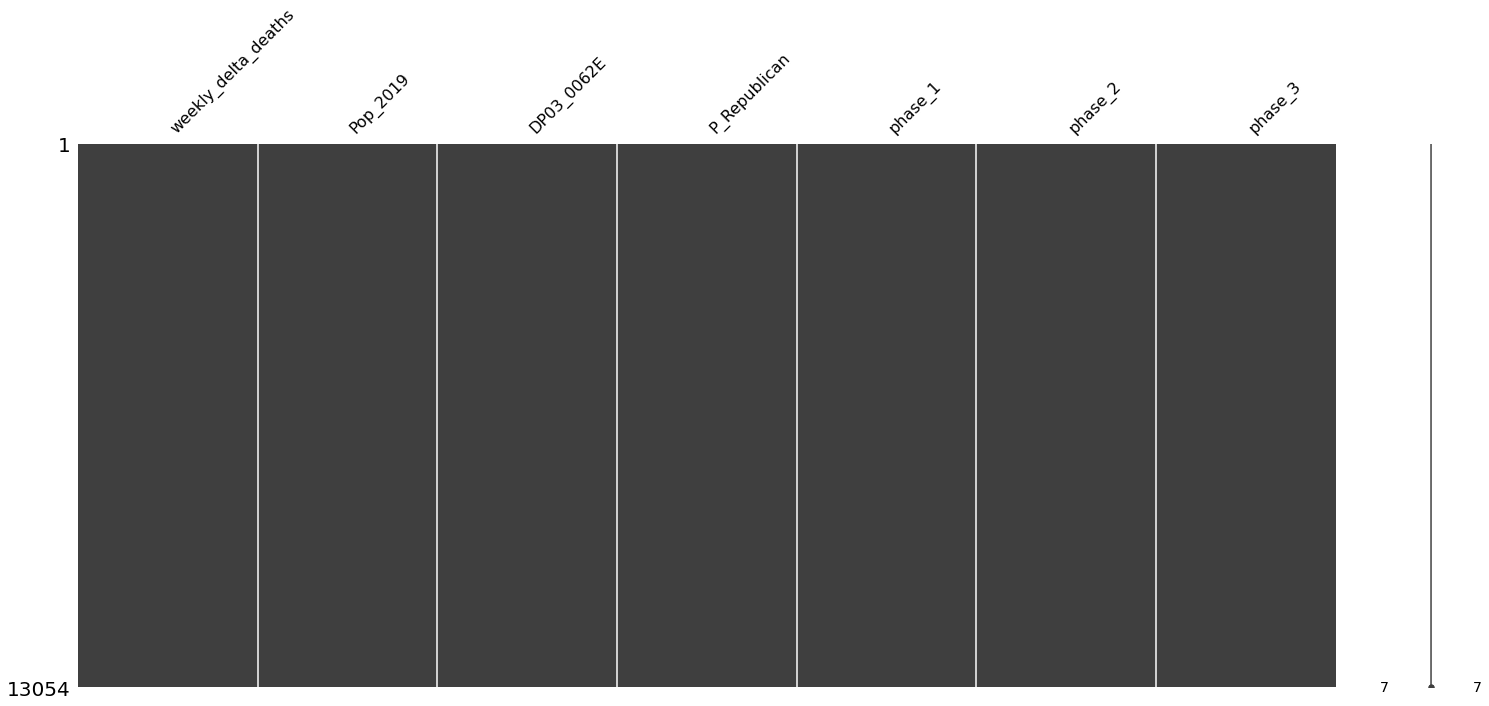

In [7]:
## Check for missing values in training data
miss.matrix(train_X)

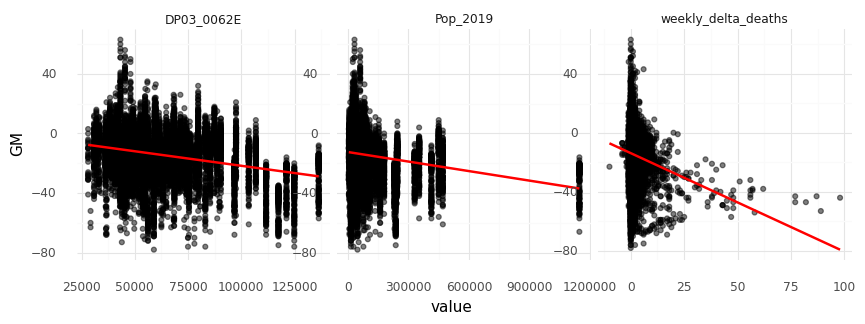

<ggplot: (128637492324)>

In [8]:
## Visualize distribution of continuous X variables against dependent variable
D = train_X[['weekly_delta_deaths','Pop_2019','DP03_0062E']].copy()
D['GM'] = train_y


(
    ggplot(D.melt(id_vars=["GM"]),
           aes(x="value",y="GM"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [9]:
## Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=12)

## Set measurement specification
use_metrics = ["neg_mean_squared_error"]

## Compare statistical models with default parameters

In [10]:
## Linear Model
lm_scores = cross_validate(LM(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [11]:
## KNN 
knn_scores = cross_validate(KNN(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [12]:
## Decision Tree
dt_scores = cross_validate(DTree(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [13]:
## Bagging
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

In [14]:
## Random Forest
rf_scores = cross_validate(RF(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

## Visualize performance of model

In [15]:
# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(LM = lm_scores['test_neg_mean_squared_error']*-1,
     KNN = knn_scores['test_neg_mean_squared_error']*-1,
     DT = dt_scores['test_neg_mean_squared_error']*-1,
     BAG = bag_scores['test_neg_mean_squared_error']*-1,
     RF = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores["Model"] = collect_scores["Model"].str.replace("LM","Linear Model")
collect_scores["Model"] = collect_scores["Model"].str.replace("DT","Decision Tree")
collect_scores["Model"] = collect_scores["Model"].str.replace("BAG","Bagging")
collect_scores["Model"] = collect_scores["Model"].str.replace("RF","Random Forest")

collect_scores

,Model,MSE
0,Linear Model,131.721714
1,Linear Model,126.100474
2,Linear Model,124.352343
3,Linear Model,117.405550
4,Linear Model,129.552726
5,KNN,56.884565
6,KNN,60.936959
7,KNN,60.690540
8,KNN,52.626442
9,KNN,61.601011


In [16]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
Viz_MSE = (
    ggplot(collect_scores,
          aes(x="Model",y="MSE", fill= "Model")) +
    geom_boxplot() +
    # scale_y_discrete(labels= (["Linear Model","KNN","Decision Tree","Bagging","Random Forest"])) +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error", title= "MSE Comparison Between Statistical Models") +
    coord_flip() +
    theme_bw() +
    theme(panel_grid_major_y = element_blank(), panel_grid_minor_x = element_blank(), legend_position = "none") +
    theme(dpi=150)
)

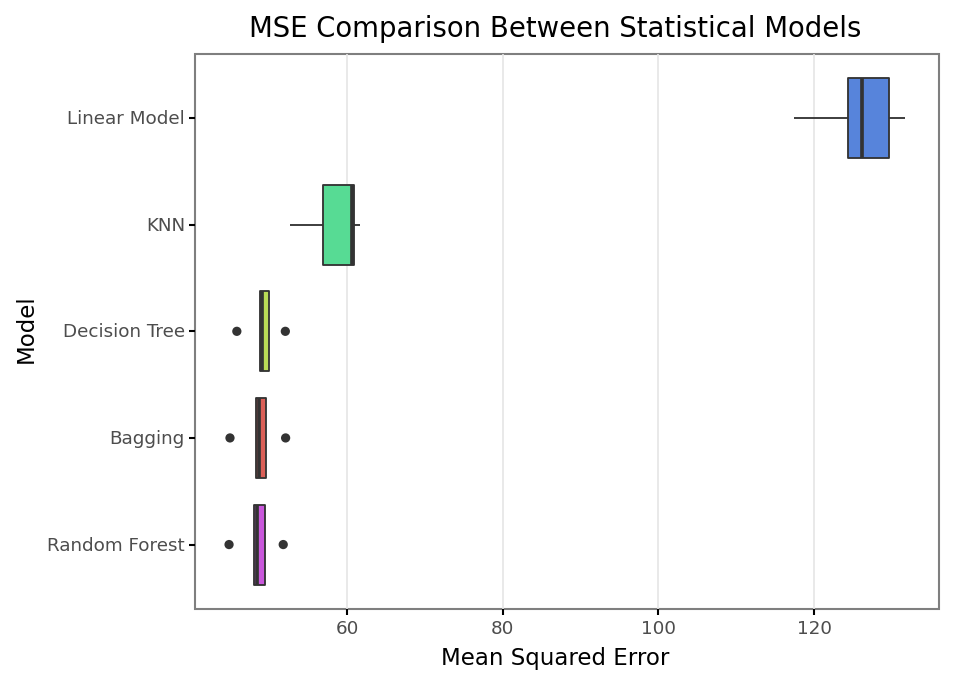

<ggplot: (128637373684)>

In [17]:
Viz_MSE

In [18]:
# Pipeline to compare all models

## Pre-Processing Specification
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), X_vars)])

## Model Pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

## Specify the models and their repsective tuning parameters.
search_space = [

    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


## Put it all together in the grid search
search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['weekly_delta_deaths',
                                                                          'Pop_2019',
                                                                          'DP03_0062E',
                                                                          'P_Republican',
                                                                          'phase_1',
                                                                          'phase_2',
                                                                          'phase_3'])])),
                                       ('model', None)]),
             n_jobs=4,
        

In [19]:
## Best Parameter
search.best_params_

## Best Score
search.best_score_ 

{'model': BaggingRegressor()}

-48.78891822475814

In [20]:
## Apply best model in prediction
pred_y = search.predict(test_X)

## Check MSE from Test X
m.mean_squared_error(test_y,pred_y)

47.05877377363152

In [21]:
## Create data frame of predictions and true value
pred = pd.DataFrame(pred_y)
compare = pd.concat([pred,test_y.reset_index(drop= True)], axis = 1).rename(columns={0: 'pred', 'retail_and_recreation_percent_change_from_baseline': 'truth'})

## Check data frame
compare.head()
compare.shape

,pred,truth
0,-26.405833,-23.0
1,-33.372302,-33.0
2,-13.628308,-22.0
3,9.058062,18.0
4,-8.843766,-11.0


(4352, 2)

In [22]:
## Visualize true value vs predicted
Viz_TruePred= (
    ggplot(compare,
          aes(x="pred",y="truth")) +
    geom_point(alpha=.3, color= "darkblue") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    labs(x= "Predicted Value", y= "True Value", title= "True Value vs Predicted of Bagging") + 
    xlim(-80,80) + 
    ylim(-80,80) +
    theme_bw() +
    theme(figure_size=(10,7))
)

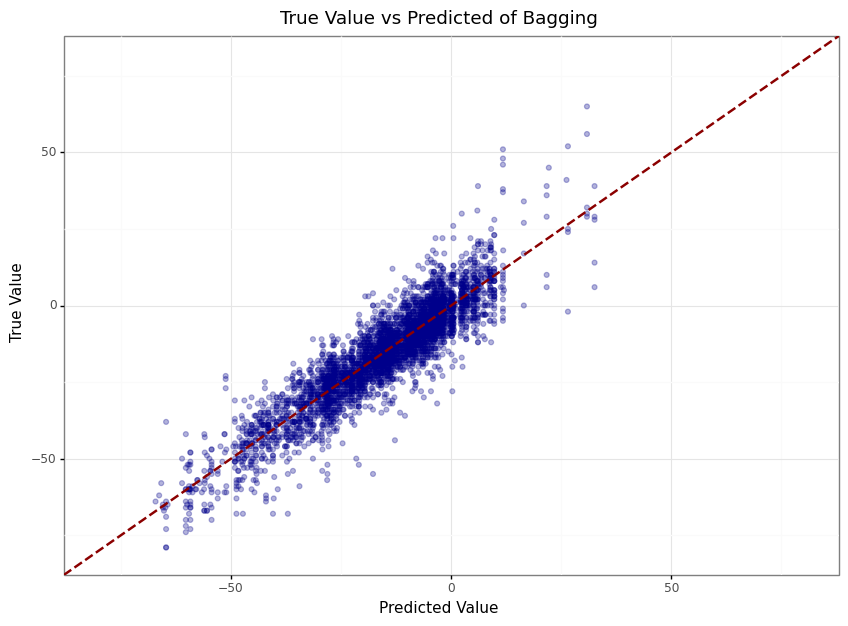

<ggplot: (128626460567)>

In [23]:
Viz_TruePred

In [24]:
## Set Best Estimator
bag = search.best_estimator_

In [25]:
## Evaluate Variable Importance with 25 runs
vi = permutation_importance(bag,train_X,train_y,n_repeats=25)

In [26]:
# Organize as a data frame 
vi_dta = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dta['low'] = vi_dta['vi'] - 2*vi_dta['std']
vi_dta['high'] = vi_dta['vi'] + 2*vi_dta['std']

# But in order from most to least important
vi_dta = vi_dta.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dta

,variable,vi,std,low,high
0,phase_3,0.859595,0.010777,0.838042,0.881149
1,P_Republican,0.577374,0.007448,0.562479,0.592269
2,DP03_0062E,0.481912,0.005168,0.471576,0.492248
3,Pop_2019,0.319731,0.006650,0.306431,0.333031
4,phase_2,0.256350,0.005288,0.245775,0.266926
5,phase_1,0.116358,0.004311,0.107737,0.124979
6,weekly_delta_deaths,0.044337,0.001965,0.040408,0.048266


In [27]:
## Visualize Variable Importance
Viz_VI= (
    ggplot(vi_dta,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.8, fill= "darkblue") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dta.variable.tolist(), labels= ['Phase 3', "Trump Support","Median Income", "Population","Phase 2","Phase 1","Weekly Net Change Deaths"]) +
    coord_flip() +
    labs(y="Reduction in AUC ROC", x="", title="Order of Variable Importance in Statistical Model\nModel 3) +
    theme(figure_size=(10,7)) +
    theme(panel_grid_major_y = element_blank(), panel_grid_minor_x = element_blank())
)

SyntaxError: EOL while scanning string literal (<ipython-input-27-3e78af6f0dc9>, line 11)

In [ ]:
Viz_VI

In [ ]:
## Partial Dependency Plot
pdp_dist = pdp.pdp_isolate(model = bag, 
                               dataset = train_X,
                               model_features = train_X.columns.tolist(),
                               feature='weekly_delta_deaths',
                               num_grid_points=20)



In [ ]:
Viz_ICE = pdp.pdp_plot(pdp_dist,'weekly_delta_deaths',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))